# Clasificador de EEG

## Importar librerías

In [1]:
#Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from matplotlib import mlab
from feature_extraction import statistics_feature_extraction as sfe

## Preparación del dataset

In [2]:
#Función de lectura de base de datos
def leer(ruta):    
    import scipy.io
    return scipy.io.loadmat(ruta, struct_as_record = True)

In [3]:
# Cargado el archivo mat
m = leer("BCICIV_1_mat\BCICIV_calib_ds1d.mat")

# Extracción del estudio
EEG = m['cnt'].T
nchannels,nsamples = EEG.shape

# Extracción de los marcadores
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]

# Extracción de la información adicional
sample_rate = m['nfo']['fs'][0][0][0][0]
channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1,cl2 = cl_lab[0],cl_lab[1]
nclases = len(cl_lab)
neventos = len(event_onsets)

# Etiquetas de inicio de clases
labels = np.zeros((1,nsamples),int)
labels[0,event_onsets] = event_codes

In [4]:
# Despliegue de información obtenida
print('Tamaño de EEG:', EEG.shape)
print('Frecuencia de muestreo:', sample_rate)
print('Número de canales:',nchannels)
print('Nombre de canales:',channel_names)
print('Número de eventos:',event_onsets.shape[1])
print('Códigos de eventos:',np.unique(event_codes))
print('Etiquetas de clases:',cl_lab)
print('Número de clases:',nclases)

Tamaño de EEG: (59, 190473)
Frecuencia de muestreo: 100
Número de canales: 59
Nombre de canales: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Número de eventos: 200
Códigos de eventos: [-1  1]
Etiquetas de clases: ['left', 'right']
Número de clases: 2


## Graficar dataset

In [5]:
from matplotlib.collections import LineCollection

def plot_eeg(EEG, chan_ind, vspace=100, color='k', titulo = 'EEG data'):
    '''
    Graficar los datos de EEG, amontonando los canales horizontalmente entre cada uno.

    Parámetros
    -------------------------------------------------------
    EEG : array (canales x muestras)
        El data de EEG
    canales : int (default 10)
        Cantidad de canales a graficar
    vspace : float (default 100)
        Espacio vertical entre los canales
    color : string (default 'k')
        Color de las señales de EEG (default negro)
    -------------------------------------------------------
    '''
    chan_ind = [channel_names.index(ch) for ch in chan_ind]
    nchans = len(chan_ind)
    bases = vspace * np.arange(nchans)

    # Calcular una línea de tiempo en segundos, sabiendo que la frecuencia de muestreo es de 100 Hz.
    time = np.arange(EEG.T.shape[0]) / sample_rate
    chan_label = []

    # Itera sobre los canales
    for i, ch in enumerate(chan_ind):
        # Graficar EEG vs tiempo
        plt.plot(time, EEG[ch].T + bases[i], color=color)
        chan_label.append(channel_names[ch])

    # # El eje y son las ubicaciones de los electrodos. Basado en el sistema internacional 10-20.
    plt.gca().yaxis.set_ticks(bases)
    plt.gca().yaxis.set_ticklabels(chan_label)

    # Agregar grid a la gráfica
    plt.grid()
    
    # Etiquetar los ejes
    plt.xlabel('Time (s)')
    plt.ylabel('Channels')
    
    # Agregar un título a la figura
    plt.title(titulo)

    plt.tight_layout()

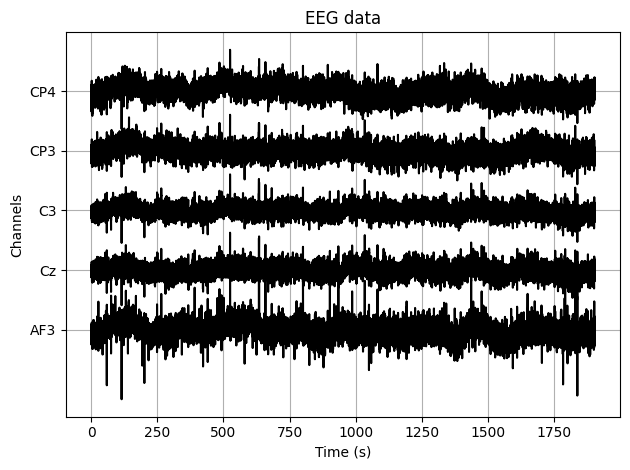

In [6]:
# Graficando el dataset
plot_eeg(
    EEG,
    ['AF3','Cz','C3','CP3','CP4'],
    2000,
    'k'
)

## Graficar un solo canal en un rango de tiempo

In [7]:
#Función para graficar una señal de la base de datos
def graficar(x,a,inicio=0,final=-1):
    if final == -1:
        plt.plot(range(inicio,x[a].size-1),x[a][inicio:final])
    else:
        plt.plot(range(inicio,final),x[a][inicio:final])

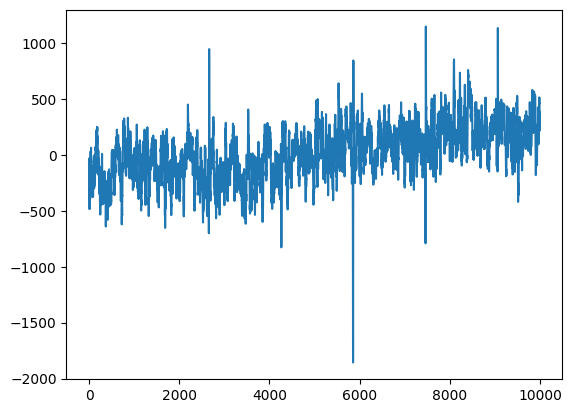

In [8]:
# Probando función
graficar(EEG,0,0,10000)

## Procesamiento de la señal

### Filtrado CAR

In [9]:
# Función para eliminar referencia promedio común (CAR) de los electrodos
def eliminar_ruido(x):
    CAR = x.mean(axis=1)
    return (x.transpose() - np.array([CAR])).transpose()

In [10]:
# Probando función
EEG = eliminar_ruido(EEG)

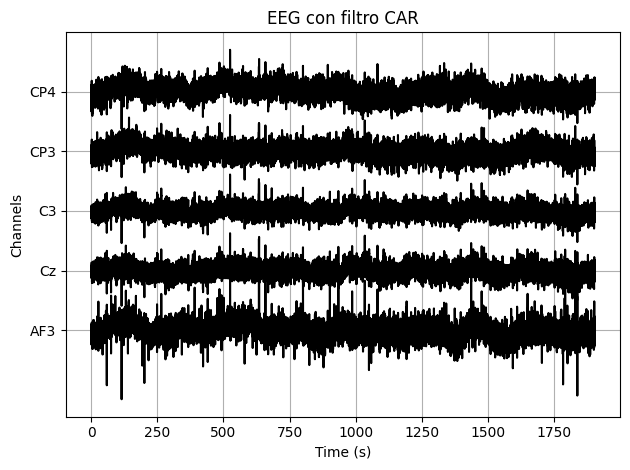

In [11]:
# Graficando el dataset filtrado CAR
plot_eeg(
    EEG,
    ['AF3','Cz','C3','CP3','CP4'],
    2000,
    'k',
    titulo = 'EEG con filtro CAR'
)

## Preparación de los eventos

In [12]:
# Separando los eventos por clases
trials = {}

# Preparación de ventana (en número de muestras) de 0.5 - 2.5 segundos
win = np.arange(int(0.5*sample_rate),int(2.5*sample_rate))
nsamples = len(win)

# Loop entre clases
for cl, code in zip(cl_lab,np.unique(event_codes)):

    # Extraer los encendidos de una clase
    cl_onsets = event_onsets[event_codes==code]

    # Ubicar en memoria los eventos
    trials[cl] = np.zeros((nchannels,nsamples,len(cl_onsets)))

    # Extraer cada evento
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:,win+onset]

# Imprimiendo información de los eventos separados por clase (canales x tiempo x evento)
print('Tamaño de evento [cl1]:',trials[cl1].shape)
print('Tamaño de evento [cl2]:',trials[cl2].shape)

Tamaño de evento [cl1]: (59, 200, 100)
Tamaño de evento [cl2]: (59, 200, 100)


### Cálculo de la Densidad Spectral de Potencia

In [13]:
def psd(trials):
    '''
    Calcula la PSD de cada trial
    
    Parámetros
    -----------------------------
    trials : Array 3D (canales x muestras x trial)

    Retornos
    ----------------------------
    trial_PSD : Array 3D (canales x PSD x trial)
    freqs : Lista de flotantes
        Frecuencia con la que fue computarizado el trial
    '''

    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels,101,ntrials))

    # Iterar sobre trials y canales
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calcular la PSD
            (PSD,freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch,:,trial] = PSD.ravel()
    
    return trials_PSD, freqs

In [14]:
# Aplicando la PSD a las dos clases
psd_1, freqs = psd(trials[cl1])
psd_2, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

In [15]:
def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Grafica la PSD calculada con (psd).

    Parámetros
    -----------------------
    trials_PSD : Array 3D
        El PSD data
    freqs : Lista de flotantes
        Las frecuencias a las que se definió el PSD
    chan_ind : Lista de enteros
        Indica los canales a graficar
    chan_lab : Lista de cadenas
        (opcional) Lista de los nombres de los canales
    maxy : Flotante
        (opcional) : Límite del eje y
    '''

    plt.figure(figsize=(12,5))

    nchans = len(chan_ind)

    # Máximo 3 gráficas por renglón
    nrows = int(np.ceil(nchans/3))
    ncols = min(3, nchans)

    # Itera sobre los canales
    for i, ch in enumerate(chan_ind):
        # Cuál subplot graficar
        plt.subplot(nrows,ncols,i+1)

        # Graficar el PSD para cada clase
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
        
        # Estilizar la gráfica
        plt.xlim(1,30)

        if maxy!= None:
            plt.ylim(0,maxy)
        
        plt.grid()
        plt.xlabel('Frecuencia (Hz)')

        if chan_lab is None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])
        
        plt.legend()
    
    plt.tight_layout()

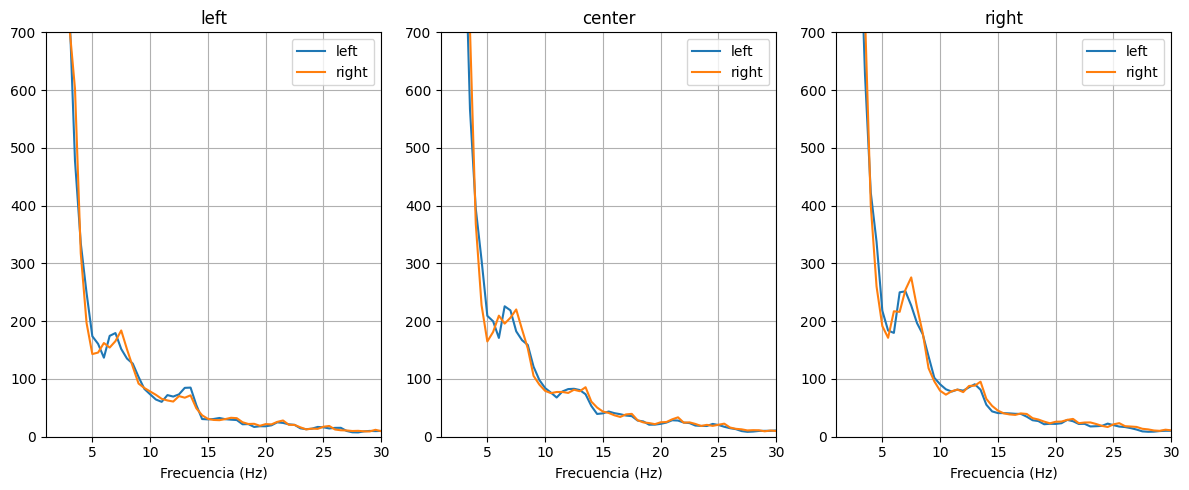

In [16]:
# Probando función plot_psd()

# 1. C3: Central, left
# 2. Cz: Central, central
# 3. C4: Central, right

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3','Cz','C4']],
    chan_lab=['left','center','right'],
    maxy=700
)

### Filtrado de la señal

In [17]:
import scipy.signal

def bandpass(trials, lo, hi, sample_rate):
    '''
    Diseña y aplica un filtro pasa banda a la señal

    Parámetros
    -----------------------
    trials : Array 3D (canales x muestras x trial)
        La señal de EEG
    lo : flotante
        Frecuencia de corte uno (Hz)
    hi : flotante
        Frecuencia de corte dos (Hz)
    sample_rate : flotante
        Frecuencia de muestreo (Hz)

    Retorno
    -----------------------
    trials_filt : Array 3D (canales x muestras x trial)
        La señal filtrada        
    '''

    a,b = scipy.signal.iirfilter(6,[lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Aplicando el filtro a cada trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels,nsamples,ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a,b,trials[:,:,i],axis=1)
    return trials_filt

In [18]:
# Probando la función
trials_filt = {cl1: bandpass(trials[cl1], 8, 30, sample_rate),cl2: bandpass(trials[cl2], 8, 20, sample_rate),}

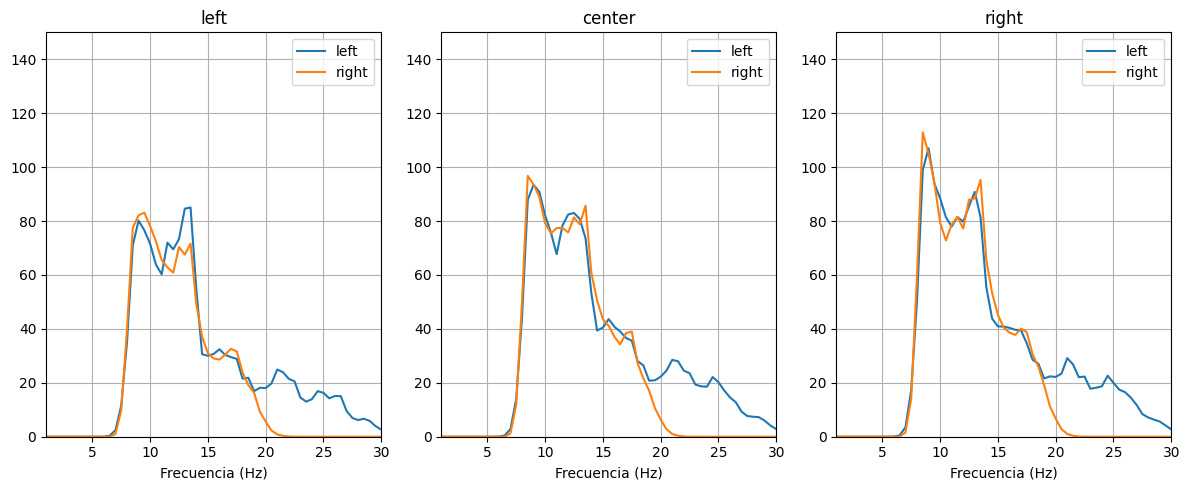

In [19]:
# Aplicando la PSD a las señales filtradas
psd_1, freqs = psd(trials_filt[cl1])
psd_2, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3','Cz','C4']],
    chan_lab=['left','center','right'],
    maxy=150
)

### Calcular el logaritmo de las pruebas

In [20]:
# Función para calcular el valor logaritmo de cada canal
def logvar(trials):
    '''
    Calcular el valor logaritmo de cada canal

    Parámetros
    ---------------------------
    trials: Array 3D (canales x muestras x trials)
        La señal de EEG.
    
    Retorno
    ---------------------------
    logvar : Array 2D (canales x trials)
        Para cada canal calcula su valor logarítmico
    '''

    return np.log(np.var(trials, axis=1))

In [21]:
# Probando la función
trials_logvar = {cl1: logvar(trials_filt[cl1]), cl2: logvar(trials_filt[cl2])}

### Función para visualizar el logaritmo de cada canal

In [22]:
def plot_logvar(trials,nchannels = nchannels):
    '''
    Graficar el valor logaritmo de cada canal

    Parámetros
    -------------------
    trials : Diccionario que contiene los trials (log-vars x trials) para 2 clases.
    '''

    plt.figure(figsize=(12,5))

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var de cada canal/componente')
    plt.xlabel('Canales/componentes')
    plt.ylabel('Log-var')
    plt.legend(cl_lab)

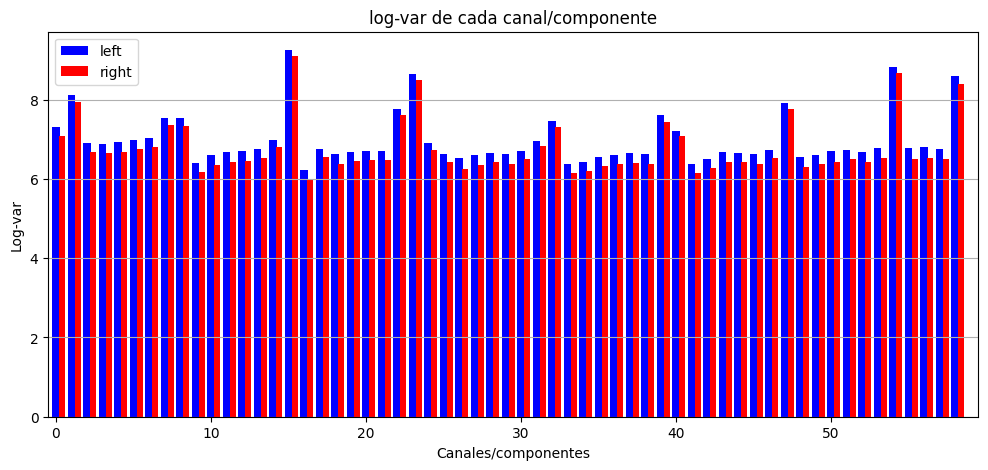

In [23]:
# Probando la función
plot_logvar(trials_logvar)

- Vemos que la mayoría de los canales muestran una pequeña diferencia en el log-var de la señal entre las dos clases.
- El siguiente paso es pasar de 59 canales a sólo unas pocas mezclas de canales.
- El algoritmo CSP calcula mezclas de canales que están diseñadas para maximizar la diferencia de variación entre dos clases.
- Estas mezclas se denominan filtros espaciales.

## Algoritmo Common Spatial Filtering (CSP)

In [24]:
from scipy import linalg
def cov(trials):
    '''Calcula la covarianza de cada prueba y entrega el promedio'''
    ntrials = trials.shape[2]
    covs = [trials[:,:,i].dot(trials[:,:,i].T) /nsamples for i in range(ntrials)]
    return np.mean(covs, axis=0)

def whitening(sigma):
    '''Calcula el whitering de una matrix de covarianza sigma'''
    U, l, _ = linalg.svd(sigma)
    return U.dot(np.diag(l ** -0.5))

def csp(trials_1, trials_2):
    '''
    Calcula la transformada CSP matriz W.

    Argumentos:
    ------------------
        trials_r : Array (canales x muestras x trials) movimientos derecha
        trials_f : Array (canales x muestras x trials) movimientos izquierda

    Retornos:
    -----------------
        Matriz mezclada W
    '''
    cov_1 = cov(trials_1)
    cov_2 = cov(trials_2)
    P = whitening(cov_1 + cov_2)
    B, _, _ = linalg.svd(P.T.dot(cov_2).dot(P))
    W = P.dot(B)
    return W

def apply_mix(W,trials):
    '''Aplica la matriz mezclada a cada trial (multiplica W con la matriz de señal EEG'''
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples,ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [25]:
# Probando la función
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),cl2: apply_mix(W, trials_filt[cl2])}

In [26]:
trials_csp['left'].shape

(59, 200, 100)

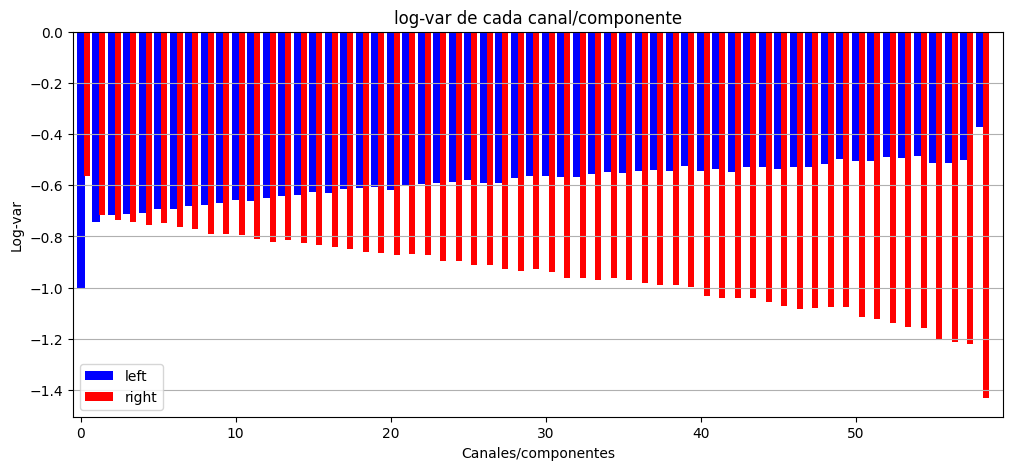

In [27]:
# Graficando log-var una vez aplicado el algoritmo CSP
trials_logvar = {cl1: logvar(trials_csp[cl1]),cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

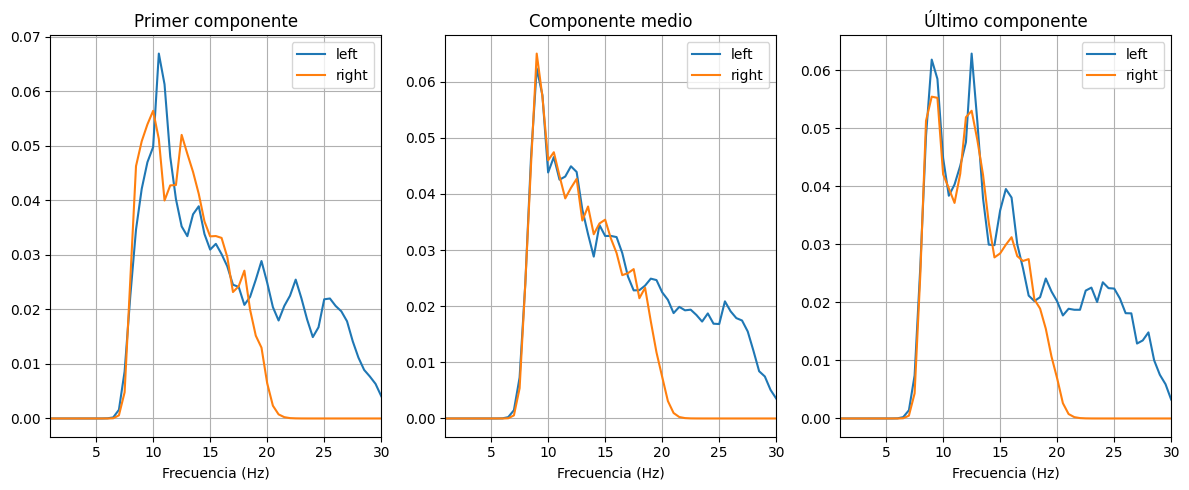

In [28]:
# Graficando PSD del CSP
psd_1, freqs = psd(trials_csp[cl1])
psd_2, freqs = psd(trials_csp[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

plot_psd(trials_PSD, freqs, 
    [channel_names.index(ch) for ch in ['C3','Cz','C4']], chan_lab = ['Primer componente', 'Componente medio', 'Último componente'])

In [29]:
def plot_scatter(one, two):
    plt.figure()
    plt.scatter(one[0,:], one[-1,:], color='b')
    plt.scatter(two[0,:], two[-1,:], color='r')
    plt.xlabel('Último componente')
    plt.ylabel('Primer componente')
    plt.legend(cl_lab)

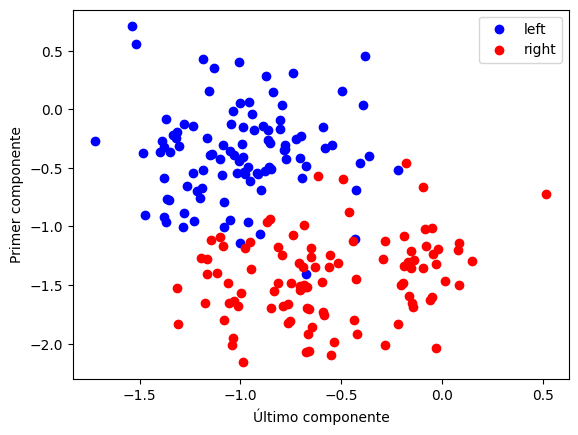

In [30]:
# Probando la función
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

## Clasificación

In [31]:
# Porcentaje de pruebas para usarse en el entranmiento
train_percentage = 0.5

In [32]:
# Calcular el número de pruebas por clase por porcentaje elegido
ntrain_1 = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_2 = int(trials_filt[cl2].shape[2] * train_percentage)

ntest_1 = trials_filt[cl1].shape[2] - ntrain_1
ntest_2 = trials_filt[cl2].shape[2] - ntrain_2

In [33]:
# Seaparando la señal filtrada en entrenamiento y prueba
train = {cl1: trials_filt[cl1][:,:,:ntrain_1],
cl2: trials_filt[cl2][:,:,:ntrain_2]}

test = {cl1: trials_filt[cl1][:,:,ntrain_1:],
cl2: trials_filt[cl2][:,:,ntrain_2:]}

In [34]:
# Entrenar el CSP únicamente con el set de entrenamiento
W = csp(train[cl1], train[cl2])

In [35]:
train[cl1].shape

(59, 200, 50)

In [36]:
W.shape

(59, 59)

In [37]:
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

In [38]:
train[cl1].shape

(59, 200, 50)

In [39]:
comp = np.array([0,-1])

ftrain = {cl1:[],cl2:[]}
ftrain[cl1] = train[cl1][comp,:,:]
ftrain[cl2] = train[cl2][comp,:,:]
ftest = {cl1:[],cl2:[]}
ftest[cl1] = test[cl1][comp,:,:]
ftest[cl2] = test[cl2][comp,:,:]

In [40]:
ftrain[cl1].shape

(2, 200, 50)

In [41]:
train[cl1] = logvar(ftrain[cl1])
train[cl2] = logvar(ftrain[cl2])
test[cl1] = logvar(ftest[cl1])
test[cl2] = logvar(ftest[cl2])

In [42]:
train[cl2].shape

(2, 50)

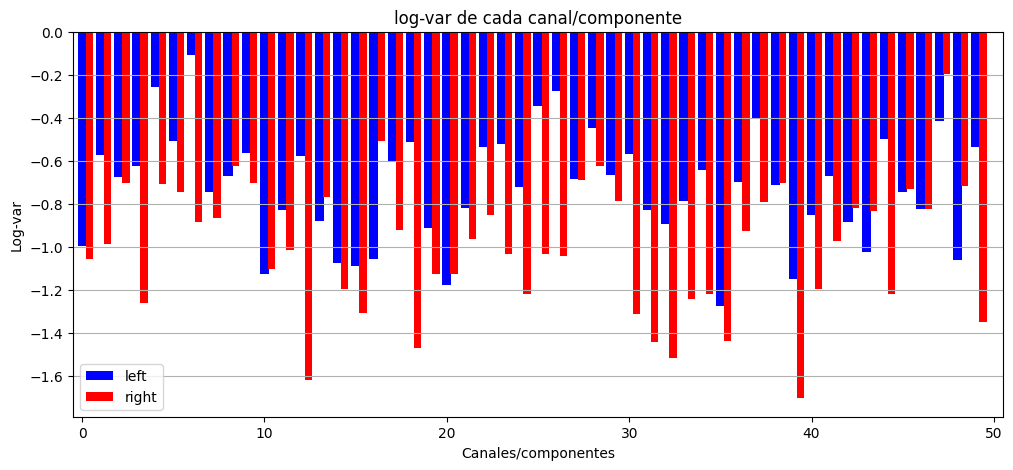

In [43]:
pato = {cl1: train[cl1].T, cl2: train[cl2].T}
plot_logvar(pato,50)

In [44]:
train[cl1].T

array([[-1.54687547, -0.44274247],
       [-0.95227523, -0.19615853],
       [-1.4455887 ,  0.09538598],
       [-0.93281551, -0.31016305],
       [-0.59661693,  0.0816934 ],
       [-0.3917019 , -0.62265374],
       [-0.55031078,  0.33492619],
       [-0.95047179, -0.54113786],
       [-1.05407103, -0.28223604],
       [-1.70541896,  0.5813127 ],
       [-1.37875566, -0.86763018],
       [-1.36979811, -0.28653198],
       [-1.09460076, -0.05905423],
       [-1.48136621, -0.27268896],
       [-1.34452541, -0.80189007],
       [-1.26334995, -0.91345356],
       [-1.70223328, -0.41098908],
       [-0.5215057 , -0.68250539],
       [-1.28504583,  0.26231703],
       [-1.33494519, -0.48726025],
       [-0.87941176, -1.47013578],
       [-1.00932927, -0.62579178],
       [-1.07289773,  0.0032636 ],
       [-0.75551264, -0.28779448],
       [-0.84098776, -0.6011465 ],
       [-0.90915765,  0.22219783],
       [-0.65434265,  0.10513013],
       [-1.0441899 , -0.32159193],
       [-0.53311022,

In [45]:
x_train = np.concatenate([train[cl1].T , train[cl2].T])
x_test = np.concatenate([test[cl1].T, test[cl2].T])

x_test.shape

(100, 2)

In [46]:
y_train = np.concatenate([np.zeros(50), np.ones(50)])
y_test = y_train
y_test.shape

(100,)

In [47]:
# Convertir el array de salidas a una codificación one_ hot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
# Cambiamos el y_train a una forma (numero de datos, etiqueta categorica)
y_train = y_train.reshape(len(y_train), 1)
# Y cambiamos a un vector one-hot
y_train_onehot = onehot_encoder.fit_transform(y_train)

# # Cambiamos el y_test a una forma (numero de datos, etiqueta categorica)
y_test = y_test.reshape(len(y_test), 1)
# Y cambiamos a un vector one-hot
y_test_onehot = onehot_encoder.fit_transform(y_test)

y_train_onehot.shape

(100, 2)

In [48]:
y_train_onehot[50]

array([0., 1.])

## Declarando la arquitectura con Keras

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(2,), activation= 'relu'),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [50]:
# Graficar la arquitectura de la red
modelo = model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 17,154
Trainable params: 17,154
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento

Antes de que el modelo este listo para entrenar , se necesitan algunas configuraciones más. Éstas son agregadas durante el paso de compilacion del modelo:

+ Loss function: Mide qué tan exacto es el modelo. Se busca minimizar su valor para dirigir el modelo en la dirección adecuada.
+ Optimizer: Cómo el modelo se actualiza basado en el set de datos que ve y la función de pérdida. Por default el factor de aprendizaje es de 0.001
+ Metrics: Métricas de validación, monitorean los pasos de entrenamiento y pruebas. El accuracy (exactitud), arroja la fración de entradas correctamente clasificadas.

In [51]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
model.fit(x_train, y=y_train_onehot, batch_size =100, epochs=15)

Epoch 1/15
1/1 [==============================] - 1s 756ms/step - loss: 0.6590 - accuracy: 0.9200
Epoch 2/15
1/1 [==============================] - 0s 6ms/step - loss: 0.6348 - accuracy: 0.9400
Epoch 3/15
1/1 [==============================] - 0s 8ms/step - loss: 0.6121 - accuracy: 0.9200
Epoch 4/15
1/1 [==============================] - 0s 6ms/step - loss: 0.5906 - accuracy: 0.9100
Epoch 5/15
1/1 [==============================] - 0s 5ms/step - loss: 0.5702 - accuracy: 0.9100
Epoch 6/15
1/1 [==============================] - 0s 6ms/step - loss: 0.5505 - accuracy: 0.9100
Epoch 7/15
1/1 [==============================] - 0s 6ms/step - loss: 0.5315 - accuracy: 0.9100
Epoch 8/15
1/1 [==============================] - 0s 5ms/step - loss: 0.5130 - accuracy: 0.9100
Epoch 9/15
1/1 [==============================] - 0s 8ms/step - loss: 0.4947 - accuracy: 0.9200
Epoch 10/15
1/1 [==============================] - 0s 6ms/step - loss: 0.4764 - accuracy: 0.9200
Epoch 11/15
1/1 [====================

In [53]:
train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=2)

print('\nExactitud en el entrenamiento:', train_acc, '\nPérdida en el entrenamiento:', train_loss, )

4/4 - 0s - loss: 0.3685 - accuracy: 0.9500 - 260ms/epoch - 65ms/step

Exactitud en el entrenamiento: 0.949999988079071 
Pérdida en el entrenamiento: 0.3685227930545807


In [54]:
test_loss, test_acc = model.evaluate(x_test,  y_test_onehot, verbose=2)

print('\nExactitud en la prueba:', test_acc, '\nPérdida en la prueba:', test_loss, )

4/4 - 0s - loss: 0.4519 - accuracy: 0.9400 - 34ms/epoch - 9ms/step

Exactitud en la prueba: 0.9399999976158142 
Pérdida en la prueba: 0.4518513083457947


In [55]:
predictions = model.predict(x_test)

4/4 [==============================] - 0s 2ms/step


In [56]:
label_dict = {0: cl_lab[0],
              1: cl_lab[1]}

In [57]:
validacion = 18
predictions[validacion]
res_predictor = np.argmax(predictions[validacion])
res_real = y_test[validacion]
print(res_real)
print('El predictor arroja una clase de tipo:', label_dict[res_predictor], ', la clase real es:', label_dict[int(res_real)], '.')

[0.]
El predictor arroja una clase de tipo: right , la clase real es: left .


### Extracción de características

In [58]:
# Función de extracción de características
def statistics_feature_extraction(x):
    import math
    import numpy as np

    vector_caracteristicas = []
    xsize = x.shape[0]

    #F1: Promedio
    promedio=x.mean()
    vector_caracteristicas.append(promedio)
    #F2: Promedio absoluto
    vector_caracteristicas.append(abs(vector_caracteristicas[0]))
    #F3: Máximo
    vector_caracteristicas.append(max(x))
    #F4: Máximo absoluto
    vector_caracteristicas.append(abs(vector_caracteristicas[2]))
    # #F5: Mínimo
    vector_caracteristicas.append(min(x))
    #F6: Mínimo absoluto
    vector_caracteristicas.append(abs(vector_caracteristicas[4]))
    #F7: Máximo + Mínimo
    vector_caracteristicas.append(vector_caracteristicas[2]+vector_caracteristicas[4])
    #F8: Máximo - Mínimo
    vector_caracteristicas.append(vector_caracteristicas[2]-vector_caracteristicas[4])

    #F9: ELIMINADA

    #F10: Longitud de curva
    sumita=0
    for i in range(xsize-1):
        sumita=sumita+abs(x[i+1]-x[i])
    vector_caracteristicas.append(sumita)
    #F11: Energía
    sumita=0
    for i in range(xsize):
        sumita=sumita+(x[i]**2)
    vector_caracteristicas.append(sumita/xsize)
    #F12: Energía no lineal promedio (ANE)
    sumita=0
    for i in range(xsize-2):
        sumita=sumita+((x[i+1]**2)-(x[i]*x[i+2]))
    vector_caracteristicas.append(sumita/xsize-2)
    #F13: Entropía espectral (SE)
    sumita=0
    for i in range(xsize):
        pk=(abs(x[i]**2))/(xsize*1.5)
        sumita=sumita+(pk*math.log2(pk))
    vector_caracteristicas.append(sumita)

    #F14: ELIMINADA

    #F15: Integral
    sumita=0
    for i in range(xsize):
        sumita=sumita+abs(x[i])
    vector_caracteristicas.append(sumita)
    #F16: Desviación estándar
    desv=x.std()
    vector_caracteristicas.append(desv)
    #F17: Varianza
    vector_caracteristicas.append(x.var())
    #F18: Oblicuidad
    sumita=0
    for i in range(xsize):
        sumita=sumita+(((x[i]-promedio)/desv)**3)
    vector_caracteristicas.append(sumita/xsize)
    #F19: Curtosis
    sumita=0
    for i in range(xsize):
        sumita=sumita+(((x[i]-promedio)/desv)**4)
    vector_caracteristicas.append(sumita/xsize)
    #F20: Sumatoria
    sumita=0
    for i in range(xsize):
        sumita=sumita+x[i]
    vector_caracteristicas.append(sumita)
    #F21: Mediana
    vector_caracteristicas.append(np.median(x))
    return vector_caracteristicas

In [59]:
def fe_trials(ftrain,train):
    cuantificador = np.zeros((50,2,20))
    for i,a in enumerate(ftrain[:,0,0]):
        for j,b in enumerate(ftrain[0,0,:]):
            vector = statistics_feature_extraction(ftrain[i,:,j])
            cuantificador[j,i,:] = np.concatenate((vector,[train[j,i]]))
    return cuantificador

In [60]:
# Seaparando la señal filtrada en entrenamiento y prueba
ftrain = {cl1: fe_trials(ftrain[cl1],train[cl1].T),
cl2: fe_trials(ftrain[cl2],train[cl2].T)}

ftest = {cl1: fe_trials(ftest[cl1],test[cl1].T),
cl2: fe_trials(ftest[cl2],test[cl2].T)}

In [61]:
ftrain[cl1].shape

(50, 2, 20)

In [63]:
x_train = np.concatenate([ftrain[cl1] , ftrain[cl2]])
x_test = np.concatenate([ftest[cl1], ftest[cl2]])

x_test.shape

(100, 2, 20)

In [64]:
x_train=x_train.reshape(-1,2*20).astype('float32')
x_test=x_test.reshape(-1,2*20).astype('float32')
x_train.shape

(100, 40)

In [65]:
y_train_onehot.shape

(100, 2)

In [66]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(40,), activation= 'relu'),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [67]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
model.fit(x_train, y=y_train_onehot, batch_size =100, epochs=15)

Epoch 1/15
1/1 [==============================] - 1s 547ms/step - loss: 4.4916 - accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 4ms/step - loss: 0.1634 - accuracy: 0.9300
Epoch 3/15
1/1 [==============================] - 0s 5ms/step - loss: 3.1409 - accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - 0s 6ms/step - loss: 0.8559 - accuracy: 0.8100
Epoch 5/15
1/1 [==============================] - 0s 6ms/step - loss: 0.1858 - accuracy: 0.9400
Epoch 6/15
1/1 [==============================] - 0s 6ms/step - loss: 0.2290 - accuracy: 0.9200
Epoch 7/15
1/1 [==============================] - 0s 6ms/step - loss: 0.5236 - accuracy: 0.8900
Epoch 8/15
1/1 [==============================] - 0s 5ms/step - loss: 0.7328 - accuracy: 0.8700
Epoch 9/15
1/1 [==============================] - 0s 5ms/step - loss: 0.7568 - accuracy: 0.8700
Epoch 10/15
1/1 [==============================] - 0s 6ms/step - loss: 0.6240 - accuracy: 0.8900
Epoch 11/15
1/1 [====================

In [69]:
train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=2)

print('\nExactitud en el entrenamiento:', train_acc, '\nPérdida en el entrenamiento:', train_loss, )

4/4 - 0s - loss: 0.3374 - accuracy: 0.9400 - 205ms/epoch - 51ms/step

Exactitud en el entrenamiento: 0.9399999976158142 
Pérdida en el entrenamiento: 0.337446391582489


In [70]:
test_loss, test_acc = model.evaluate(x_test,  y_test_onehot, verbose=2)

print('\nExactitud en la prueba:', test_acc, '\nPérdida en la prueba:', test_loss, )

4/4 - 0s - loss: 0.3406 - accuracy: 0.9500 - 41ms/epoch - 10ms/step

Exactitud en la prueba: 0.949999988079071 
Pérdida en la prueba: 0.3406234383583069
